In [7]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors

from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import cv2 as cv
import os

np.random.seed(42)

In [8]:
colors_dict = mcolors.CSS4_COLORS
colors_list = np.random.permutation(list(colors_dict.keys()))

In [9]:
google_drive_dir = 'drive/My Drive/'
dataset_dir = 'skin-cancer-mnist-ham10000/'
metadata_csv_name = 'HAM10000_metadata.csv'
metadata_cleared_csv_name = 'HAM10000_metadata_preprocessed.csv'
isColab = False

### Launch this if you are working at Google Colab

In [0]:
isColab = True

### Get full path to dataset

In [10]:
if isColab:
  dataset_path = google_drive_dir + dataset_dir
else:
  dataset_path = dataset_dir

dataset_path

'skin-cancer-mnist-ham10000/'

### Read dataset

In [11]:
skin_df = pd.read_csv(dataset_path + metadata_csv_name)

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [12]:
skin_df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

## Data Cleaning

In [13]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [14]:
skin_df['age'].replace(to_replace=0, value=int(skin_df['age'].mean()))
skin_df['age'].fillna(int((skin_df['age'].mean())), inplace=True)

In [15]:
skin_df['age'].value_counts()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
51.0      57
10.0      41
0.0       39
Name: age, dtype: int64

In [16]:
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

## Add Column with Full Name of Disease

In [17]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)

## Encode categorical data

In [23]:
# Diseases (dx) One-Hot DataFrame
dx_onehot = pd.get_dummies(skin_df['dx'], prefix='dx')

#Diseases Types (dx_codes) One-Hot DataFrame
dx_type_onehot = pd.get_dummies(skin_df['dx_type'], prefix='dx_type')

# Sex One-Hot DataFrame
sex_onehot = pd.get_dummies(skin_df['sex'], prefix='sex')

# Disease Localization One-Hot DataFrame
localization_onehot = pd.get_dummies(skin_df['localization'], prefix='localization')

# Create List of New DataFrames to Concatenate Them
data_frames_list = [
    skin_df,
    dx_onehot,
    dx_type_onehot,
    sex_onehot,
    localization_onehot
]

# Final DataFrame
df_preprocessed = pd.concat(data_frames_list, axis=1)
df_preprocessed.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,dx_akiec,dx_bcc,...,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,0,...,0,0,0,0,0,0,1,0,0,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,0,...,0,0,0,0,0,0,1,0,0,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,0,...,0,0,0,0,0,0,1,0,0,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,0,...,0,0,0,0,0,0,1,0,0,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_preprocessed.to_csv(dataset_path + metadata_cleared_csv_name)

### Just to check if everything is OK

In [25]:
cleared_df = pd.read_csv(dataset_path + metadata_cleared_csv_name)
cleared_df.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,dx_akiec,...,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,...,0,0,0,0,0,0,1,0,0,0
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,...,0,0,0,0,0,0,1,0,0,0
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,...,0,0,0,0,0,0,1,0,0,0
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0,...,0,0,0,0,0,0,1,0,0,0
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,0,...,0,0,0,0,0,0,0,0,0,0


## Data Exploration

### Diseases Distribution

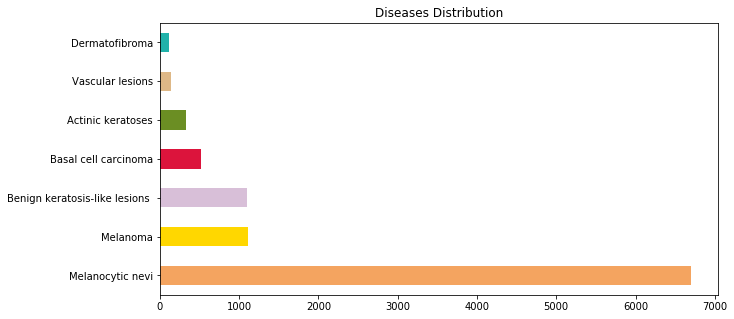

In [26]:
cell_type_counts = cleared_df['cell_type'].value_counts()
colors = colors_list[:len(cell_type_counts)]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.title.set_text('Diseases Distribution')
cell_type_counts.plot(kind='barh', ax=ax, color=colors);

### Diseases Type Distribution

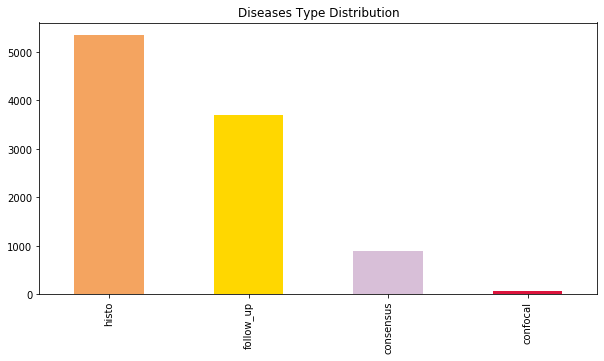

In [27]:
dx_type_counts = cleared_df['dx_type'].value_counts()
colors = colors_list[:len(dx_type_counts)]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.title.set_text('Diseases Type Distribution')
dx_type_counts.plot(kind='bar', ax=ax, color=colors);

### Localization of Disease

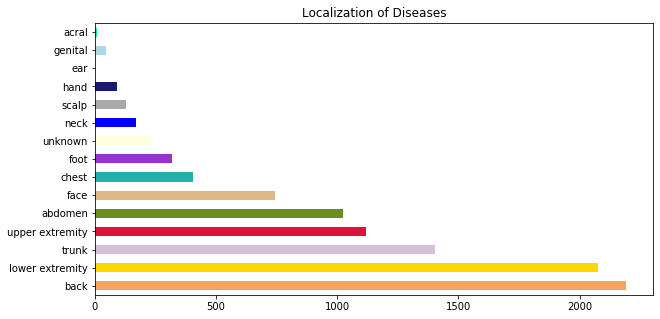

In [29]:
localization_counts = cleared_df['localization'].value_counts()
colors = colors_list[:len(localization_counts)]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.title.set_text('Localization of Diseases')
localization_counts.plot(kind='barh', ax=ax, color=colors);

### Age Distribution

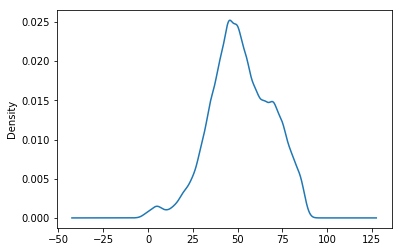

In [279]:
cleared_df['age'].plot.kde();